In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
# load model
actor = branch_actor((2,),(2,))
#actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.load_weights('../saved_agent/linear_init_extend_actor.h5')
critic = critic_net((2,),(2,))[0]
#critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
critic.load_weights('../saved_agent/linear_init_extend_critic_l.h5')

In [152]:
def value_function_ap(state, actor, critic):
    state = np.array(state).reshape((1,1,) + state.shape)
    action = actor.predict_on_batch(state)
    value = critic.predict_on_batch([action, state])[0][0]
    return value


def value_function(state, actor, env, step_limit=1000, n_episodes=10, alpha=0.4, beta=1., ln=1.):
    ave = 0
    for ep in range(n_episodes):
        tmp = []
        env.reset()
        env.set_state(state)
        episode_reward = 0
        acc_time = 0
        for steps in range(step_limit):
            reward = 0
            x = env.state
            a_agent, tau = actor.predict(x.reshape((1,1,) + x.shape))[0]
            action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
            dt = .01
            #action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
            #dt = tau / action_repetition
            for p in range(action_repetition):
                _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
                r *= np.exp(- alpha * dt * p)
                reward += r
            reward *= dt
            reward -= beta # step reward

            episode_reward += np.exp(- alpha * acc_time) * reward
            tmp.append(episode_reward)
            acc_time += tau
        ave += episode_reward
    ave = ave / n_episodes
    return episode_reward, tmp

def td_error(experience, actor, value_net, mode):
    state0, action, reward, state1 = experience
    if mode == 'true':
        v0, _ = value_function(state0, actor, env, step_limit=200, n_episodes=1, ln=0)
        discount = np.exp(- alpha * action[1])
        v1, _ = value_function(state1, actor, env, step_limit=200, n_episodes=1, ln=0)
        td = (v0 - (reward + discount * v1))**2
    elif mode == 'pred':
        v0 = value_net.predict_on_batch(state0.reshape(1,1,2))[0][0]
        discount = np.exp(- alpha * action[1])
        v1 = value_net.predict_on_batch(state1.reshape(1,1,2))[0][0]
        td = (v0 - (reward + discount * v1))**2
    else:
        assert 1, 'argument `mode` should be `true` or `pred`.'
    return td

# 真のvalue_functionはTDを0にする？

In [6]:
vn = value_net((2,))
vn.load_weights('../saved_agent/value_net_init.h5')

In [23]:
actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
# actor.load_weights('../saved_agent/linear_init_extend_actor.h5')

In [81]:
alpha = 0.4
beta = 1.

memory = []
S1 = np.linspace(-7, 7, 100)
S2 = np.linspace(-7, 7, 100)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    env.reset()
    x = np.array(x)
    env.set_state(x)
    reward = 0
    state0 = env.state
    a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0]
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, 0)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(i*100/len(S1))} %', end='')
memory = np.array(memory)

99 %

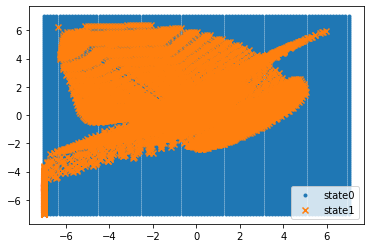

In [82]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.legend()
plt.show()

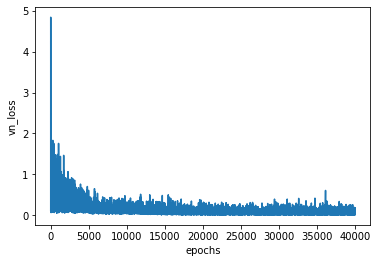

In [137]:
# critic learning
vn.compile(Adam(lr=0.01, clipnorm=1.), loss='mean_squared_error')
vn.load_weights('../saved_agent/value_net_learned.h5')
epoch = 40000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    target = vn.predict_on_batch(state1_batch)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    loss = vn.train_on_batch(state0_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('vn_loss')
plt.show()

## 近似$V^{\pi}(s)$とシミュレーションベースの$V^{\pi}(s)$はTDどのくらい？

In [154]:
m = memory[np.random.choice(range(len(memory)))]
print(m)

[array([ 0.77777778, -4.31313131]) array([0.63186204, 0.70839417])
 -1.4714519359026048 array([-2.34575964, -0.92691129])]


In [155]:
# vn.load_weights('../saved_agent/value_net_learned.h5')
tdt = td_error(m, actor, vn, 'true')
tdp = td_error(m, actor, vn, 'pred')

In [159]:
print(f'td_error of simulation(dt=0.01) base V(s): {tdt}') # ほぼ0なので, 正しいsimulationなのがわかった
print(f'td_error of neural net V(s): {tdp}')

td_error of simulation(dt=0.01) base V(s): 1.262177448353619e-29
td_error of neural net V(s): 0.030149093484889533


In [140]:
# tdを小さくするように学習したV(s)はじゃあどのくらいの精度？？
for i in range(10):
    m = memory[np.random.choice(range(len(memory)))]
    state0, action, reward, state1 = m
    print(state0)
    vt, _ = value_function(state0, actor, env, step_limit=200, n_episodes=1, ln=0)
    vp = vn.predict_on_batch(state0.reshape(1,1,2))[0][0]
    print(vt, vp)
    print()

[3.18181818 5.86868687]
-6.099752195687909 -6.057548

[1.76767677 5.02020202]
-5.461817465356787 -5.3447127

[-5.72727273 -1.76767677]
-4.897078226188078 -4.9677525

[7.         4.03030303]
-6.2016949368207 -6.1364145

[0.49494949 5.86868687]
-5.956796708617955 -5.785675

[ 2.47474747 -0.35353535]
-3.859927419485908 -3.9014218

[0.91919192 0.07070707]
-3.446852275024893 -3.4056025

[-1.76767677  4.87878788]
-5.78163087593432 -6.167243

[-6.57575758  1.76767677]
-6.04199667648164 -6.074139

[-1.48484848  3.60606061]
-5.257889302732597 -4.874398



## value function の形を知りたい

In [165]:
%%time
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

vts, vps = [], []

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    vts.append(value_function(state, actor, env, step_limit=200, n_episodes=1, ln=0)[0])
    vps.append(vn.predict_on_batch(state.reshape(1,1,2))[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

vts = np.array(vts) # linear_vts_learned.csv
vps = np.array(vps) # linear_vps_learned.csv

99 %CPU times: user 13min 27s, sys: 12.9 s, total: 13min 40s
Wall time: 14min 33s


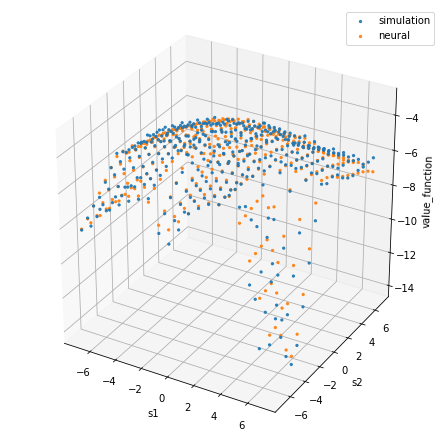

In [170]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value_function')

ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts, marker='.', alpha=0.9, label='simulation')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps, marker='.', alpha=0.9, label='neural')
plt.legend()